In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import datetime
import calendar

import matplotlib.pyplot as plt 
import seaborn as sns

from pathlib import Path

PATH = Path(os.getcwd()).parent
os.chdir(PATH)
from src.helper import *

%matplotlib inline

### Data Prep

In [2]:
# Analyse student history data
path = 'karnataka_monthly_royalty.xlsx'

df = read_file(path)

In [3]:
df.head()

,s.no,region,state,area_name,lcl_code,lcl_name,location_name,student_name,student_code,school_name,invoice_no,invoice_date,invoice_month,receipt_date,payment_mode,course_fee,receipt_amt,discount_amt,late_fee,royalty_fee
0,1.0,NaN,KARNATAKA,KARNATAKA,6404.0,BHARGAVI GOUTHAMI P,SIP ABACUS - KENGERI,ABHI KRISHNA R GOWDA,SA640415136,NaN,AINV20214770,02-01-2021,JAN-21,21-01-2021,CASH,1300.0,1300.0,0.0,0.0,355.0
1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,PRAJWAL C GOWDA,SA640417175,NaN,AINV20214771,02-01-2021,JAN-21,24-01-2021,CASH,1300.0,1300.0,0.0,0.0,355.0
2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,DISHA R,SA640418006,NaN,AINV20214772,02-01-2021,JAN-21,24-01-2021,CASH,1300.0,1300.0,0.0,0.0,355.0
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,VIBHU P HIREMATH,SJ640418015,SJR SCHOOL,AINV20214773,02-01-2021,JAN-21,31-01-2021,CASH,1300.0,1300.0,0.0,0.0,355.0
4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,AYUSHREE S K,SJ640418022,SJR SCHOOL,AINV20214774,02-01-2021,JAN-21,21-01-2021,CASH,1300.0,1300.0,0.0,0.0,355.0


In [4]:
# Convert payment_mode to CASH and CHEQUE only
df['payment_mode'] = df['payment_mode'].apply(clean_payment_mode)

In [5]:
useful_cols = ['lcl_name', 'location_name', 'student_name', 'school_name', 
               'receipt_date', 'payment_mode', 'course_fee', 'receipt_amt', 
               'discount_amt', 'late_fee', 'royalty_fee']

df = df[useful_cols]

In [6]:
df = df.dropna(subset=['student_name'])

In [7]:
df = add_datetime_cols(df, 'receipt_date')

In [8]:
# Fill nulls under lcl_name and location_name

df.loc[:, ['lcl_name', 'location_name']] = df[['lcl_name', 'location_name']].fillna(method='ffill')

In [9]:
df = df.sort_values(by=['lcl_name', 'receipt_date'])

In [10]:
df.head()

,lcl_name,location_name,student_name,school_name,receipt_date,payment_mode,course_fee,receipt_amt,discount_amt,late_fee,royalty_fee,receipt_month,receipt_year
621,ANITHA RANI K M,SIP ABACUS - CHAMARAJPET,VEDIKA R KUMAR,JNANODAYA,2021-01-01,CASH,1102.0,1300.36,0.0,0.0,291.0,1,2021
644,ANITHA RANI K M,SIP ABACUS - CHAMARAJPET,LAVISHA JAIN,BRIGADE MILLENIUM,2021-01-01,CASH,1102.0,1300.36,0.0,0.0,291.0,1,2021
647,ANITHA RANI K M,SIP ABACUS - CHAMARAJPET,SATHVIKA M,V V N,2021-01-01,CASH,1102.0,1300.36,0.0,0.0,291.0,1,2021
692,ANITHA RANI K M,SIP ABACUS - CHAMARAJPET,ROHIT KRISHNAN L,NaN,2021-01-02,CASH,1102.0,1300.36,0.0,0.0,291.0,1,2021
1000,ANITHA RANI K M,SIP ABACUS - CHAMARAJPET,HARSHVARDHAN K JAIN,SRI AUROBINDO MEMORIAL SCHOOL,2021-01-02,CASH,1102.0,1300.36,0.0,0.0,291.0,1,2021


### Basic Questions

In [11]:
YEAR = 2021
df = df[df['receipt_year'] == YEAR].reset_index(drop=True)

**How many LCLs are there as of 2021?**

In [12]:
df['lcl_name'].nunique()

18

**How many centers are there?**

In [13]:
df['location_name'].nunique()

31

**How many students paid fees in 2021?**

In [14]:
df['student_name'].nunique()

4155

**How did the number of students who paid the fees paid vary over months?**

In [15]:
student_count_monthly = student_monthly_dist(df)

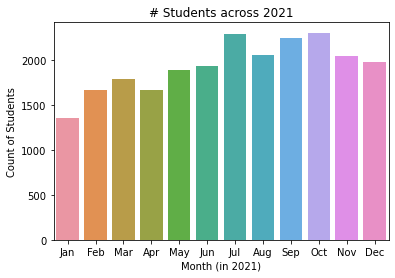

In [16]:
# Plot
sns.barplot(data=student_count_monthly, x='receipt_month', y='student_name')
plt.title(f'# Students across {YEAR}')
plt.xlabel(f'Month (in {YEAR})')
plt.ylabel('Count of Students');

**What is the total royalty earned by SIP Karnataka in 2021?**

In [17]:
total_royalty_earned = round(df[df['receipt_year'] == 2021]['royalty_fee'].sum(), 2)

In [18]:
total_royalty_earned

9954168.12

**How did the royalty earned vary over the months?**

In [19]:
royalty_monthly = df.groupby('receipt_month')['royalty_fee'].sum().reset_index()
royalty_monthly.loc[:, 'receipt_month'] = royalty_monthly['receipt_month'].apply(lambda x: calendar.month_abbr[x])

royalty_monthly['royalty_fee'] = royalty_monthly['royalty_fee']/100000

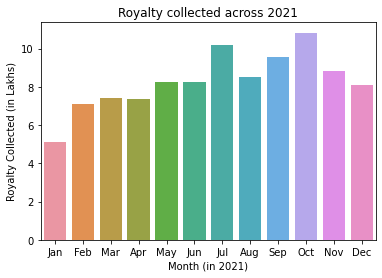

In [20]:
# Plot
sns.barplot(data=royalty_monthly, x='receipt_month', y='royalty_fee')
plt.title(f'Royalty collected across {YEAR}')
plt.xlabel(f'Month (in {YEAR})')
plt.ylabel('Royalty Collected (in Lakhs)');

Notes:
1. Jan royalty seems especially low. Can dig in a bit deeper into why this happened.
2. July and October royalties are significantly higher than Jan (2x)

As an aside, student count is a good proxy for royalty paid. Rather, royalty is a simple function of # students.

**Which are the top 10 centers in terms of student count, royalty?**

In [21]:
df.groupby('location_name')['student_name'].nunique().sort_values(ascending=False).reset_index().head(10)

,location_name,student_name
0,SIP ABACUS - CHAMARAJPET,660
1,SIP ABACUS - UTTARAHALLI,620
2,SIP ABACUS - VIJAYA NAGAR,463
3,SIP ABACUS - RANEBENNUR,423
4,SIP ABACUS - KASAVANAHALLI,365
5,SIP ABACUS - BASAVANAGUDI,263
6,SIP ABACUS - PATIL NAGAR,219
7,SIP ABACUS - HOSAKEREHALLI,186
8,SIP ABACUS - JAYA NAGAR,177
9,Sip Abacus- Banashankari,146


In [22]:
df.groupby('location_name')['royalty_fee'].sum().sort_values(ascending=False).reset_index().head(10)

,location_name,royalty_fee
0,SIP ABACUS - UTTARAHALLI,1625071.00
1,SIP ABACUS - CHAMARAJPET,1615661.40
2,SIP ABACUS - KASAVANAHALLI,1452487.00
3,SIP ABACUS - VIJAYA NAGAR,1111451.40
4,SIP ABACUS - BASAVANAGUDI,709268.00
5,SIP ABACUS - RANEBENNUR,487211.52
6,SIP ABACUS - HOSAKEREHALLI,444477.00
7,SIP ABACUS - JAYA NAGAR,365424.00
8,Sip Abacus- Banashankari,306335.00
9,SIP ABACUS - PATIL NAGAR,273570.00


**Which are the bottom 10 centers?**

In [23]:
df.groupby('location_name')['student_name'].nunique().sort_values(ascending=False).reset_index().tail(10)

,location_name,student_name
21,GENIUL HUB- KANAKANAGAR,15
22,BRIGHT BRAIN- HOSAKEREHALLI,14
23,JALA VIDYA EDU CENTER- VIDHYARANYAPURA,14
24,BRILLIANT ACADEMY- KOPPAL,9
25,PRERANA FOUNDATION- KALABURAGI,9
26,ANKURA CENTRE FOR LEARNING-BANGALORE,8
27,ABACUS AND BRAIN GYM CENTRE- KENGERI UPANAGAR,5
28,BANASHANKARI 2ND STAGE,1
29,BUDDING GENIUS- KASAVANAHALLI,1
30,KIDS CASTLE BTM,1


**Average Royalty per student, by center**

In [24]:
# Avg royalty collected per student?
center_stats = df.groupby('location_name')[['student_name', 'royalty_fee']].agg({'student_name': 'nunique',
                                                                                 'royalty_fee': 'sum'})
center_stats = center_stats.reset_index()
center_stats = center_stats.rename({'student_name': 'student_count'}, axis=1)

center_stats['royalty_per_student'] = round(center_stats['royalty_fee']/center_stats['student_count'], 2)
center_stats = center_stats.sort_values(by='royalty_per_student', ascending=False)

In [25]:
center_stats.head()

,location_name,student_count,royalty_fee,royalty_per_student
12,SIP ABACUS - KASAVANAHALLI,365,1452487.0,3979.42
20,SIP ABACUS - KANAKA NAGAR,83,230705.0,2779.58
13,SIP ABACUS - BASAVANAGUDI,263,709268.0,2696.84
26,SIP ABACUS - UTTARAHALLI,620,1625071.0,2621.08
29,SIP ABACUS - SHANTHI NAGAR,48,125641.0,2617.52


**Distribution of Royalty Fee**

In [26]:
df.describe()

,course_fee,receipt_amt,discount_amt,late_fee,royalty_fee,receipt_month,receipt_year
count,32266.000000,32266.000000,32266.000000,32266.000000,32266.000000,32266.000000,32266.0
mean,1170.582029,1282.705029,45.613321,22.995333,308.503320,6.917529,2021.0
std,476.323107,505.772050,308.481598,293.217687,117.803382,3.318010,0.0
min,630.000000,100.000000,0.000000,0.000000,147.760000,1.000000,2021.0
25%,1102.000000,1300.000000,0.000000,0.000000,291.000000,4.000000,2021.0
50%,1102.000000,1300.360000,0.000000,0.000000,291.000000,7.000000,2021.0
75%,1200.000000,1300.360000,0.000000,0.000000,317.000000,10.000000,2021.0
max,17500.000000,20150.270000,5340.000000,5340.000000,3804.000000,12.000000,2021.0


**What are the top schools from which students are joining?**

In [47]:
df['school_name'].value_counts().head(10)

CARMEL SCHOOL                  716
NATIONAL PUBLIC SCHOOL         674
JAIN PUBLIC SCHOOL             606
LITTLE FLOWER PUBLIC SCHOOL    475
RNS                            448
DELHI PUBLIC SCHOOL            433
SFS HIGHSCHOOL                 389
BIPS                           375
PRARTHANA SCHOOL               365
CITY INTERNATIONAL             342
Name: school_name, dtype: int64

In [40]:
df.location_name.unique()

array(['SIP ABACUS -  CHAMARAJPET ', 'ANIKETHANA ACADEMY- CHAMARAJPET',
       'SIP ABACUS -  JAYA NAGAR', 'SIP ABACUS -  BTM LAYOUT',
       'KIDS CASTLE BTM', 'SIP ABACUS -  PATIL NAGAR',
       'BRILLIANT ACADEMY- KOPPAL', 'SIP ABACUS - SHANTHI NAGAR',
       'SIP ABACUS -  KENGERI',
       'ABACUS AND BRAIN GYM CENTRE- KENGERI UPANAGAR',
       'SIP ABACUS -  VIJAYA NAGAR', 'SIP ABACUS -  RANEBENNUR',
       'Sip Abacus-  Banashankari', 'BANASHANKARI 2ND STAGE',
       'SIP ABACUS -  KANAKA NAGAR', 'GENIUL HUB- KANAKANAGAR',
       'SIP ABACUS -   KASAVANAHALLI', 'BUDDING GENIUS- KASAVANAHALLI',
       'SIP ABACUS -  VIDHYARANYAPURA',
       'JALA VIDYA EDU CENTER- VIDHYARANYAPURA',
       'SIP ABACUS -  KALABURAGI', 'PRERANA FOUNDATION- KALABURAGI',
       'SIP ABACUS -  SUNKADAKATTE',
       'ANKURA CENTRE FOR LEARNING-BANGALORE',
       'SIP ABACUS -  SRIRAMAPURAM', 'SIP ABACUS -  KALLIKERE',
       'SIP ABACUS -  UTTARAHALLI', 'SIP ABACUS -  HOSAKEREHALLI',
       'BRIGHT BRAIN

**Deep Dive into SIP KVH**

In [36]:
df_kvh = df[df['location_name'] == 'SIP ABACUS -   KASAVANAHALLI']

In [37]:
student_count_monthly = student_monthly_dist(df_kvh)

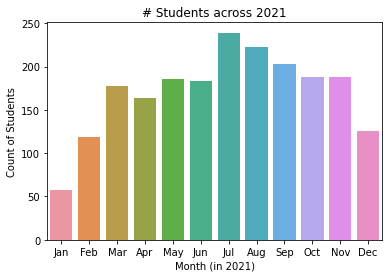

In [39]:
# Plot
sns.barplot(data=student_count_monthly, x='receipt_month', y='student_name')
plt.title(f'# Students across {YEAR}')
plt.xlabel(f'Month (in {YEAR})')
plt.ylabel('Count of Students');

**Deep Dive into SIP Basvangudi**

In [41]:
df_basava = df[df['location_name'] == 'SIP ABACUS -  BASAVANAGUDI']

In [42]:
student_count_monthly = student_monthly_dist(df_basava)

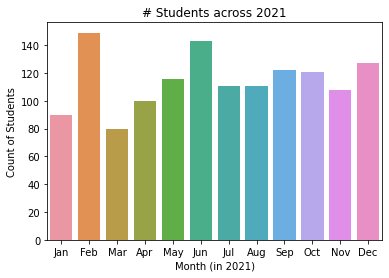

In [43]:
# Plot
sns.barplot(data=student_count_monthly, x='receipt_month', y='student_name')
plt.title(f'# Students across {YEAR}')
plt.xlabel(f'Month (in {YEAR})')
plt.ylabel('Count of Students');